# MVA Cours Numerical PDEs for image analysis

## TP 1.1 Dense automatic differentiation

The objective of this practical works session is to implement an automatic differentiation class, using dense storage, and explore some of its applications.

**Note:** 
The purpose of these experiments is to illustrate the conceptual simplicity of automatic differentiation.
In practical applications, it is not recommended to develop these tools from scratch, but to use a mature software package. (As we will do in next sessions.)

## 0. Importing the required libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## 1. Implementation

In [2]:
class Dense:
    """
    A class for Dense, first order, forward automatic differentiation.
    Members : 
    - x : an array of arbitrary shape (n_1,...,n_k)
    - v : an array of shape (size_ad, n_1,...,n_k), where size_ad is arbitrary integer
    
    Represents the following Taylor expansion, where h is a symbolic perturbation
    x + sum(h[i]*v[i] for i in range(size_ad)) + o(\|h\|)
    """
    
    def __init__(self,x,v):
        self.x = x
        self.v = np.asarray(v)
        assert np.shape(x) == np.shape(v)[1:]
    
    def __repr__(self):
        return f"Dense({self.x},{self.v})"
    
    @property
    def size_ad(self): 
        """The number of independent components of the symbolic perturbation (denoted h)"""
        return len(self.v)
    
    def convert(self,other):
        if isinstance(other,Dense): # Checks that self and other have matching size_ad
            assert self.size_ad==other.size_ad 
            return other
        else: # Return Dense object with matching size_ad
            return Dense(other,np.zeros(shape=(self.size_ad,*np.shape(other))))
    
    # Base arithmetic operators
    def __add__(self,other):
        a,b = self,self.convert(other)
        return Dense(a.x+b.x, a.v+b.v)
    
    def __sub__(self,other):
        a,b = self,self.convert(other)
        return Dense(a.x-b.x,a.v-b.v)
    
    def __mul__(self,other):
        a,b = self,self.convert(other)
        return Dense(a.x*b.x, a.x*b.v + a.v*b.x)

    def __truediv__(self,other):
        a,b = self,self.convert(other)
        return Dense(a.x/b.x, a.v/b.x - a.x*b.v/b.x**2)

    # Other operators
    def __neg__(self): return Dense(-self.x,-self.v)
    __radd__ = __add__
    __rmul__ = __mul__
    def __rsub__(self,other):     return self.convert(other)-self
    def __rtruediv__(self,other): return self.convert(other)/self
    
    
    # Special functions
    def __pow__(self,r):
        x,v = self.x,self.v
        return Dense(x**r, r*x**(r-1) * v)
    
    def sqrt(self): 
        s = np.sqrt(self.x)
        return Dense(s,self.v/(2*s))
    
    def sin(self):
        s,c = np.sin(self.x),np.cos(self.x)
        return Dense(s,c*self.v)

    # Element access
    def __getitem__(self,key):
        return Dense(self.x[key],self.v[:,key])
    def __setitem__(self,key,other):
        a,b = self,self.convert(other)
        a.x[key]   = b.x[key]
        a.v[:,key] = b.v[:,key]
   
# Create some sample variables for testing purposes
a = Dense(1.,[1.,2.]) # 1 + (h_0 + 2*h_1) + o(|h|)
b = Dense(2.,[3.,4.]) # 2 + (3*h_0+4*h_1) + o(|h|)

In [3]:
def close_to_zzero(a): 
    """Checks that a Taylor expansion has its zeroth and first order components close to zero."""
    return np.allclose(a.x,0) and np.allclose(a.v,0)

### 1.1 String representation

Task: Implement the `Dense.__repr__` method. It should return a string containing a readable representation of the object, that (ideally) can be used to reconstruct it.

In [4]:
# Hint : Python's string formatting syntax
x,y,z = 1,'bla',[1,2,3]
print(f"I got the variables : {x} and {y} (and also {z=})")

I got the variables : 1 and bla (and also z=[1, 2, 3])


In [5]:
print(a)

Dense(1.0,[1. 2.])


### 1.2 Arithmetic operators

*Task:* Implement the `Dense.__add__` and `Dense.__sub__` methods. They must return a `Dense` object, in accordance with the Taylor expansion rules.
For instance:
$$
    (x + <v,h> + o(\|h\|)) + (x'+<v',h>+o(\|h\|)) = (x+x') + <(v+v'),h> + o(\|h\|)
$$

In [6]:
print(f"Addition : {a+b=}")     # Operator + is __add__
print(f"Substraction : {a-b=}") # Operator * is __sub__

Addition : a+b=Dense(3.0,[4. 6.])
Substraction : a-b=Dense(-1.0,[-2. -2.])


In [7]:
assert close_to_zzero(a+b-a-b) # Unit test for checking implementation

*Task:* Implement the `Dense.__mul__` method, which must be in accordance with the following Taylor expansion:
$$
    (x + <v,h> + o(\|h\|)) + (x'+<v',h>+o(\|h\|)) = (x x') + <(x v'+x' v),h> + o(\|h\|)
$$

In [8]:
print(f"Multiplication {a*b=}")  # Operator * is __mul__
print(f"Division {a/b=}")        # Operator / is __truediv__

Multiplication a*b=Dense(2.0,[5. 8.])
Division a/b=Dense(0.5,[-0.25  0.  ])


In [9]:
assert close_to_zzero(a*b/a/b - 1) # Unit test for checking implementation

### 1.3 Other arithmetic operators

**Unary negation**

*Task:* Implement the unary negation `__neg__` operator.

In [10]:
print(f"Unary negation {-a=}")

Unary negation -a=Dense(-1.0,[-1. -2.])


In [11]:
assert close_to_zzero(-a+a) # Unit test for checking implementation

**Operators acting on the right**

When the python interpreter encounters the expression `a-b`:
- it attempts to evaluate it as `a.__sub__(b)`
- catches the error if the previous operation is not implemented, for instance if `a` is `float` and `b` is `Dense` 
- if needed, attempts to evaluate the sum as  `b.__rsub__(a)`

Since addition and multiplication are commutative (for the mathematical object of interest here), their implementation is slightly simpler than substraction and division.

*Task:* Implement the `__rmul__` and `__rdiv__` operations. 

In [12]:
print(f"Right multiplication {2*a=}")
print(f"Right division {2/a=}")

Right multiplication 2*a=Dense(2.0,[2. 4.])
Right division 2/a=Dense(2.0,[-2. -4.])


In [13]:
assert close_to_zzero(2./(2./a) - a)

### 1.4 Special functions

Special functions, whose derivative is usually known explicitly, act on Taylor expansions as 
$$
    f(x + <v,h> + o(\|h\|)) = f(x) + <f'(x) v, h> + o(h).
$$

*Task:* Implement the `sqrt` and `sin` methods of the `Dense` class.

In [14]:
print(f"Square root function {np.sqrt(a)=}")
print(f"Sine function {np.sin(a)=}")

Square root function np.sqrt(a)=Dense(1.0,[0.5 1. ])
Sine function np.sin(a)=Dense(0.8414709848078965,[0.54030231 1.08060461])


In [15]:
assert close_to_zzero(np.sqrt(a**2)-a)
assert close_to_zzero(np.sin(np.pi-a) - np.sin(a))

## 2. Applications (one variable)

We use the `Dense` automatic differentiation class to differentiate functions and solve for their roots.
For that purpose, let us introduce an arbitrary test function, made from methods supported by our class.

In [16]:
def f(x): return x + x**2 + np.sin(2*x) - 0.2

The function value and derivative at a point $x$ are contained in its first order Taylor expansion 
$$
    f(x+h+o(h)) = f(x) + f'(x) h + o(h).
$$
For convenience, let us build a function that turns a scalar value $x$ into the formal Taylor expansion $x+h+o(h)$.

In [17]:
def scalar_ad(x): return Dense(x,[1.])

Now, as announced, we can get `f(x) = f(x_ad).x` and `f'(x) = f(x_ad).v[0]`, where `x_ad = scalar_ad(x)`.

In [18]:
x=0.
x_ad = scalar_ad(x) # x+h+o(h)
print(f"Taylor expansion {f(x_ad)=} of f at {x=}")
print(f"{f(x)=}, and f'(x)={f(x_ad).v[0]}")

Taylor expansion f(x_ad)=Dense(-0.2,[3.]) of f at x=0.0
f(x)=-0.2, and f'(x)=3.0


### 2.1 Solve an equation using the Newton method

The basic Newton method to solve the equation 
$$
    f(x)=0,
$$
is initialized from an arbitrary $x_0$, and then defines
$$
    x_{n+1} := x_n - f(x_n)/f'(x_n).
$$
Obviously, the `Dense` automatic differentiation class must be used in the method.

*Task :* implement the Newton method, with a fixed number $N$ of iterations, returning the last value $x_N$.

In [19]:
def Newton(f,x,niter):
    for i in range(niter):
        x_ad = scalar_ad(x)
        f_ad = f(x_ad)
        x -= f_ad.x/f_ad.v[0]
    return x

In [20]:
root = Newton(f,0,10)
print(f"Solved for f : {root=}")
print(f"Residual : {f(root)=}")

Solved for f : root=0.06536643515057672
Residual : f(root)=0.0


### 2.2 Plot a function and its derivative

Numpy is designed to automatically thread many operations over arrays, which is convenient for both readability and performance.

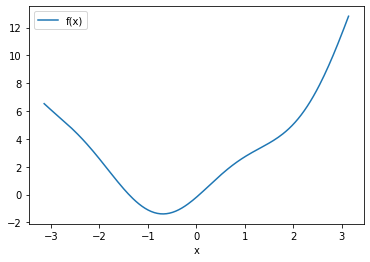

In [21]:
X = np.linspace(-np.pi,np.pi,200)
plt.plot(X,f(X),label="f(x)")
plt.xlabel("x")
plt.legend();

However our `scalar_ad` function is designed for single scalar value `x`, not an array of values.

*Task:* Modify the function `scalar_ad` to properly handle arrays of values.
If `x` has shape $(n_1,...,n_k)$ then `v` should be an array of ones with shape $(1,n_1,...,n_k)$. 
(One can assume $k\in\{0,1\}$ for simplicity.)

In [22]:
def scalar_ad(x): return Dense(x,np.ones((1,*np.shape(x))))

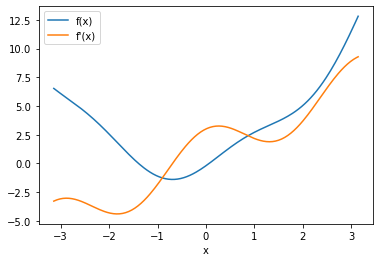

In [23]:
X_ad = scalar_ad(X)
f_ad = f(X_ad)
plt.plot(X,f_ad.x,label="f(x)")
plt.plot(X,f_ad.v[0],label="f'(x)")
plt.xlabel("x")
plt.legend();

## 2. Applications (several variables)

In several dimensions, it is convenient to construct vectors whose components are subject to independent symbolic perturbations.


*Task:* complete the function `vector_ad` below. Given a vector $(x_i)_{1 \leq i \leq I}$, it should return a variable of `Dense` class representing the Taylor expansion
$$
    (x_i + h_i + o(h))_{1\leq i \leq I}.
$$

In [24]:
def vector_ad(x):
    assert np.ndim(x)==1
    return Dense(x,np.eye(len(x)))

### 2.1 Gradient descent

We propose to use automatic differentiation to minimize a function by gradient descent.

In [25]:
def f(x): return x[0]**2+x[1]**2 + np.sin(2*x[0])-np.sqrt(1+x[1]**2-x[1])

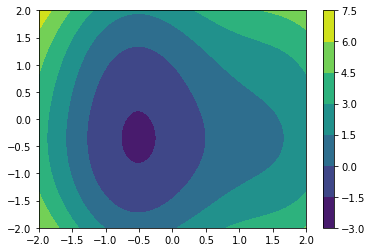

In [26]:
aX = np.linspace(-2,2,100)
X = np.array(np.meshgrid(aX,aX,indexing='ij'))
plt.contourf(*X,f(X))
plt.colorbar();

*Task:* Implement the `GradientDescent` method.

In [27]:
def GradientDescent(f,x,niter,step=0.1):
    x_ = [x.copy()]
    x_ad = vector_ad(x)
    for i in range(niter):
        f_ad = f(x_ad)
        x_ad.x -= step*f(x_ad).v
        x_.append(x.copy())
    return x_

In [28]:
x0 = np.array([1.5,1.5])
x_ = GradientDescent(f,x0,30)

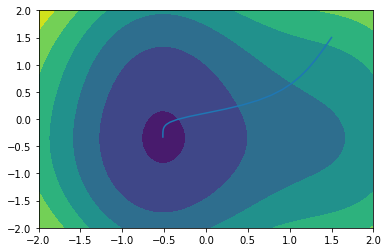

In [29]:
plt.contourf(*X,f(X))
plt.plot(*np.array(x_).T);

### 2.2 Hamilton's equations of geodesics

Hamilton's equations characterize geodesics paths on manifolds, and appear in numerous other physical models as well. They read:
$$
    \frac {dq}{dt} = \partial_p H, \qquad \frac {dp}{dq} = -\partial_q H.
$$

*Task:* Implement a basic ODE solver of Hamilton's equations, using automatic differentiation to differentiate the Hamiltonian.

In [30]:
def Hamilton(H,q,p,niter,step=0.1):
    q_ = [q.copy()]
    p_ = [p.copy()]
    q_ad = vector_ad(q)
    p_ad = vector_ad(p)
    for i in range(niter):
        q_ad.x += step* H(q,p_ad).v
        p_ad.x -= step* H(q_ad,p).v
        q_.append(q.copy())
        p_.append(p.copy())
    return q_,p_

We use the Hamiltonian of the Poincare hyperbolic plane model, reading
$$
    H(q,p) = \frac {q_1} 2 (p_0^2+p_1^2).
$$
It is defined for states $q \in R \times R_+$, and arbitrary impulsions $p \in R^2$. One can prove that the geodesics follow circular arcs.

*Task:* Implement this Hamiltonian.

In [31]:
def H(q,p): return 0.5*q[1]**2 * (p[0]**2+p[1]**2)

In [32]:
q = np.array([0.,1.])
θ = 1.
p = np.array([np.cos(θ),np.sin(θ)])

q_,p_ = Hamilton(H,q,p,100)

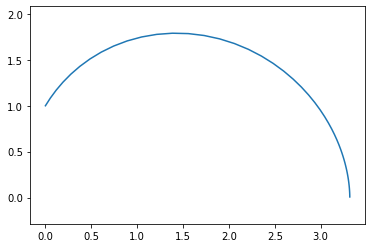

In [33]:
plt.plot(*np.array(q_).T)
plt.axis('equal');

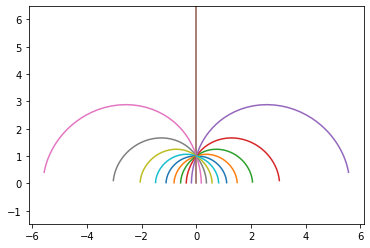

In [34]:
for θ in np.linspace(0,2*np.pi,20,endpoint=False):
    q = np.array([0.,1.])
    p = np.array([np.cos(θ),np.sin(θ)])
    q_,p_ = Hamilton(H,q,p,50)
    plt.plot(*np.array(q_).T)
plt.axis('equal');
plt.ylim(0,5);